In [1]:
import xarray as xr
from xmitgcm import open_mdsdataset
import xgcm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
import matplotlib.animation as animation
from fastjmd95 import rho
import sys
warnings.filterwarnings("ignore")

dsState = xr.open_dataset('TPOSE6_Hourly_Oct2012.nc',engine='netcdf4')


In [2]:

print('density')
sigma_0 = (rho(dsState.SALT, dsState.THETA, 0)-1000)

# TIW filter
fs = 1/3600
highF = (1/(15*24))*fs # equivalent to 15 days per cycle
lowF = (1/(40*24))*fs
order = 4
cutoff = [lowF, highF]
sos = butter(order, cutoff, 'bandpass', fs=fs, output='sos')


density


In [3]:
dTdx = (dsState.THETA[:,:,1:,:].values - dsState.THETA[:,:,:-1,:].values)/(1/6)

tmp = dsState.THETA[:,:,:-1,:].copy(deep=True)
tmp.values = dTdx
tmp.name = 'dTdx'
dTdx = tmp 

dTdx_filt = sosfiltfilt(sos, dTdx, axis=3)
tmp = dsState.THETA[:,:,:-1,:].copy(deep=True)
tmp.values = dTdx_filt
tmp.name = 'dTdx_filt'
dTdx_filt = tmp 

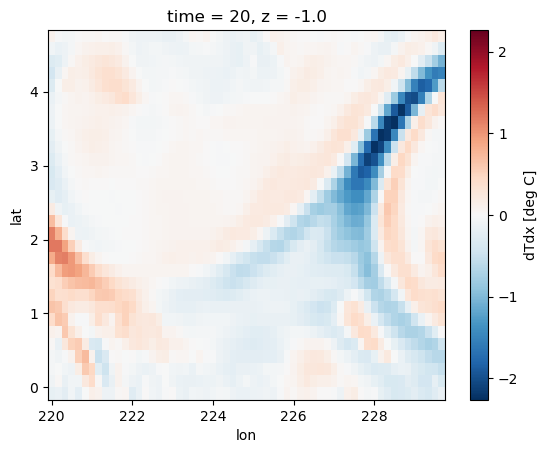

In [4]:
dTdx.sel(time=[20.0],method='nearest').isel(z=0).plot()

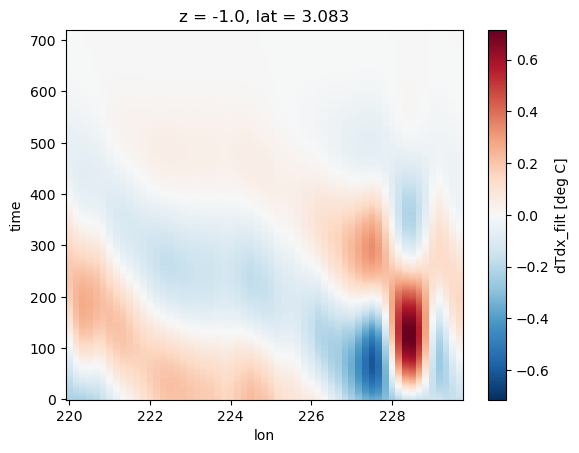

In [5]:
dTdx_filt.sel(lat=[3.0],method='nearest').isel(z=0).T.plot()

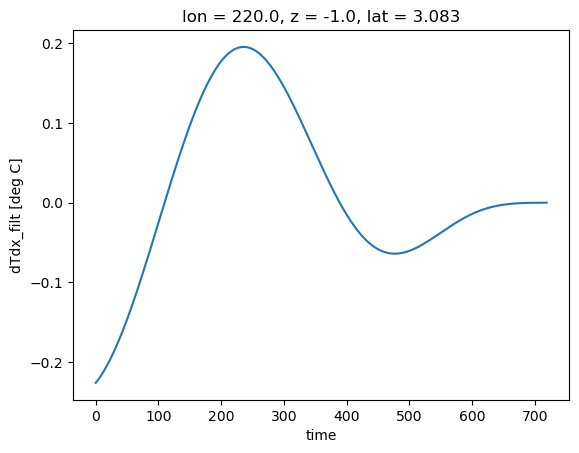

In [6]:
dTdx_filt.sel(lat=[3.0],lon=[220.0],method='nearest').isel(z=0).T.plot()

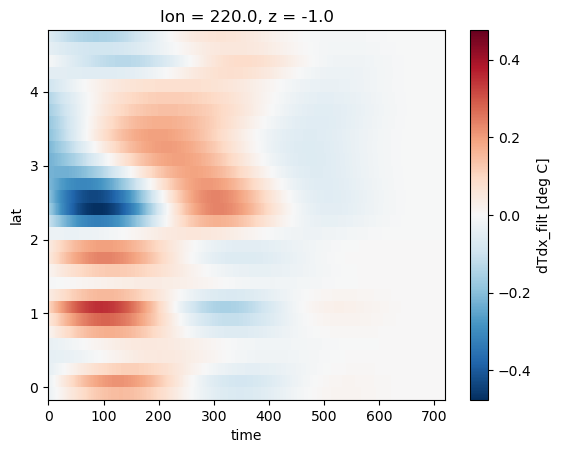

In [18]:
dTdx_filt.sel(lon=[220.0],method='nearest').isel(z=0).plot()

In [4]:
# print('barotropic flow') # depth average
barotropic_w = dsState.WVEL.mean(dim='z')
baroclinic_w = dsState.WVEL - barotropic_w
# TIW filter
fs = 1/3600
lowF = (1/(15*24))*fs # equivalent to 15 days per cycle
order = 4
cutoff = [highF]
sos = butter(order, cutoff, 'highpass', fs=fs, output='sos')
baroclinic_w_filt = sosfiltfilt(sos, baroclinic_w.values, axis=1)

tmp = dsState.WVEL.copy(deep=True)
tmp.values = baroclinic_w_filt
tmp.name = 'baroclinic_w_filt'
baroclinic_w_filt = tmp 

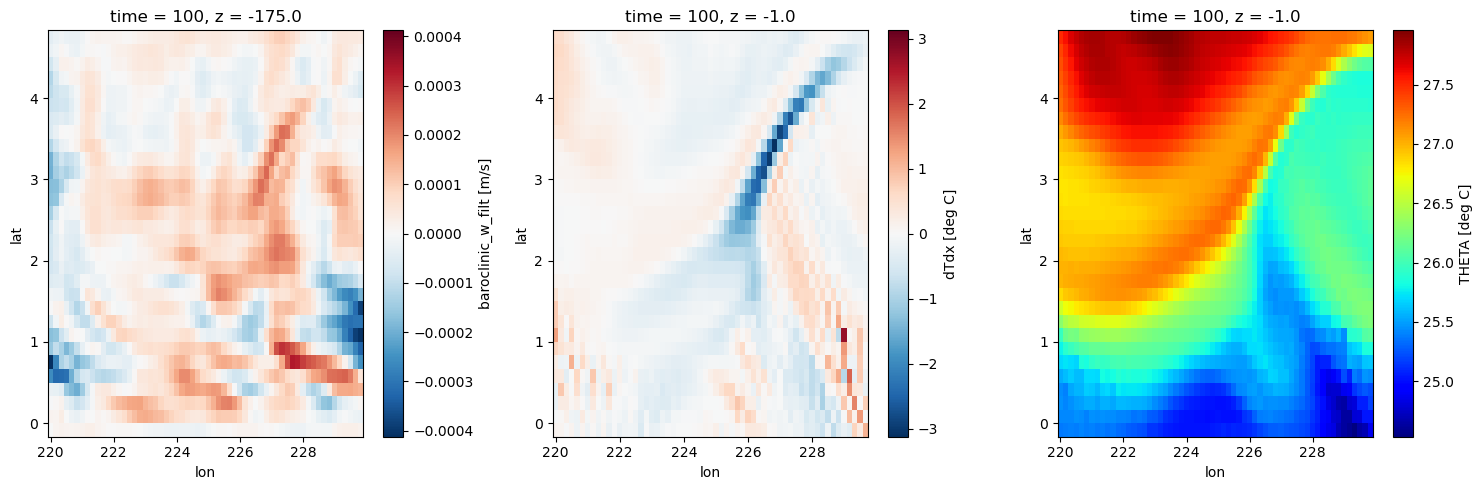

In [5]:
fig, ax = plt.subplots(figsize=(15,5),ncols=3)
baroclinic_w_filt.sel(time=[100.0],z=[-180.0],method='nearest').plot(ax=ax[0])
dTdx.sel(time=[100.0],z=[0.0],method='nearest').plot(ax=ax[1])
dsState.THETA.sel(time=[100.0],z=[0.0],method='nearest').plot(ax=ax[2],cmap='jet')
plt.tight_layout()

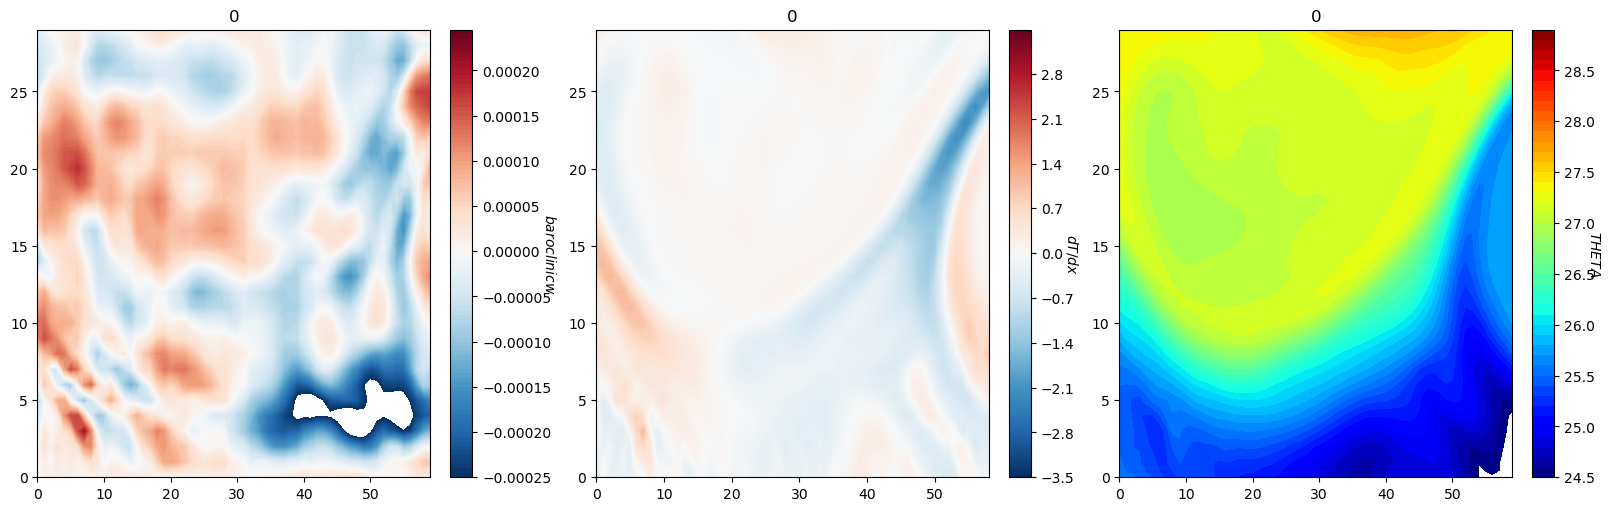

In [9]:
fig, ax = plt.subplots(figsize=(16,5),ncols=3,constrained_layout=True)
pos1 = ax[0].contourf(baroclinic_w_filt.sel(time=0,z=[-180.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
ax[0].set_xlabel('Lon')
ax[0].set_ylabel('Lat')
cbar1 = fig.colorbar(pos1,ax=ax[0])
cbar1.set_label('$baroclinic w$', rotation=270)

# add contours of phi
pos2 = ax[1].contourf(dTdx.sel(time=0,z=[0.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-3.5,3.5,0.01))
ax[1].set_xlabel('Lon')
ax[1].set_ylabel('Lat')
cbar2 = fig.colorbar(pos2,ax=ax[1])
cbar2.set_label('$dT/dx$', rotation=270)

# add wind vectors and vertical shear contours
pos3 = ax[2].contourf(dsState.THETA.sel(time=0,z=[0.0],method='nearest').squeeze(),cmap='jet',levels=np.arange(24.5,29,0.1))
ax[2].set_xlabel('Lon')
ax[2].set_ylabel('Lat')
cbar3 = fig.colorbar(pos3,ax=ax[2])
cbar3.set_label('$THETA$', rotation=270)

startDay = 0

def update(frame):

    day = frame + startDay 
    ax[0].clear()
    pos1 = ax[0].contourf(baroclinic_w_filt.sel(time=day,z=[-180.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
    # pos1.set_data(data)
    ax[0].set_title(str(day))

    ax[1].clear()
    pos2 = ax[1].contourf(dTdx.sel(time=day,z=[0.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-3.5,3.5,0.01))
    # pos2.set_data(data)
    ax[1].set_title(str(day))

    ax[2].clear()
    pos3 = ax[2].contourf(dsState.THETA.sel(time=day,z=[0.0],method='nearest').squeeze(),cmap='jet',levels=np.arange(24.5,29,0.1))
    # pos3.set_data(data)
    ax[2].set_title(str(day))

    return (pos1,pos2,pos3)

video = animation.FuncAnimation(fig=fig, func=update, frames=len(dsState.time),interval=100)
videostr = "Tiw_animation_hourly.mp4"
video.save(filename=videostr, writer="ffmpeg")

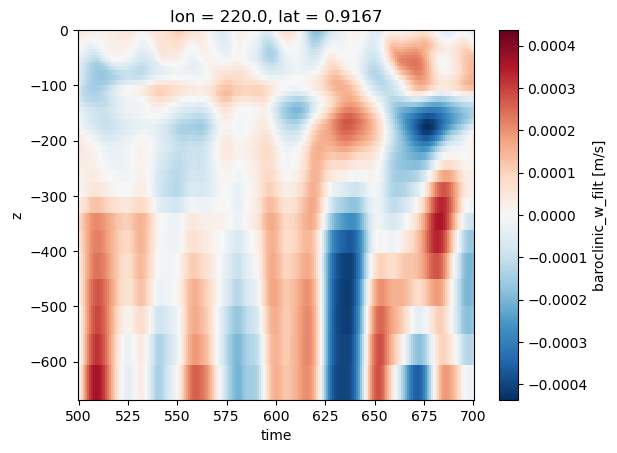

In [10]:
sigma_plot = sigma_0.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)).squeeze()

baroclinic_w_filt.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)).plot(cmap='RdBu_r')
# ax[0].set_title('w\'')
# CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
# ax[0].clabel(CS)


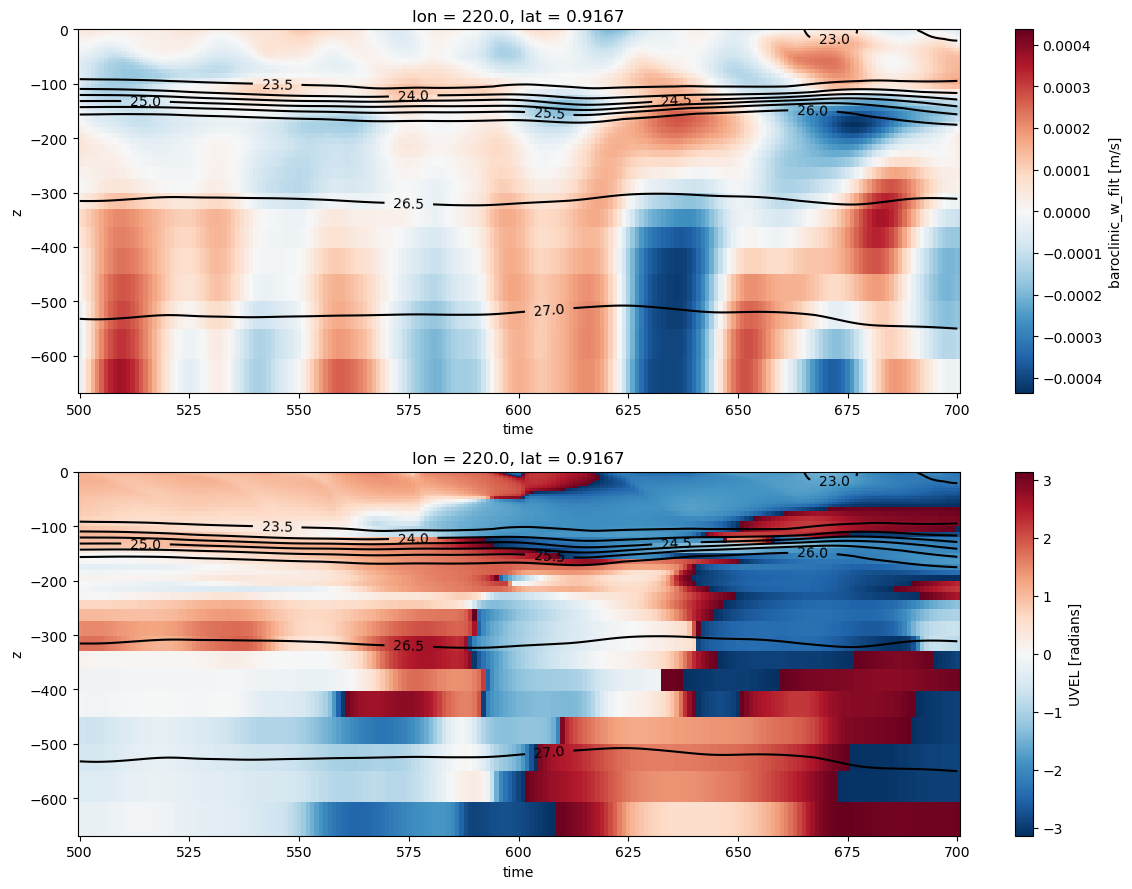

In [13]:
sigma_plot = sigma_0.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)).squeeze()
v_prof = dsState.VVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)).mean('time')
v_anom = dsState.VVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)) - v_prof
u_prof = dsState.UVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)).mean('time')
u_anom = dsState.UVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)) - u_prof

angle = np.arctan2(u_anom,v_anom)
angle.attrs['units'] = 'radians'
angle.attrs['name'] = 'angle'

fig, ax = plt.subplots(figsize=(12,9),nrows=2)
baroclinic_w_filt.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(500,700)).plot(ax=ax[0],cmap='RdBu_r')
ax[0].set_title('w\'')
CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(CS)

angle.plot(ax=ax[1],cmap='RdBu_r')
ax[1].set_title('du/dz')
CS = sigma_plot.plot.contour(ax=ax[1],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(CS)

plt.tight_layout()

In [37]:
dudz = (dsState.UVEL[1:,:,:,:].values - dsState.UVEL[:-1,:,:,:].values)/(dsState.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-dsState.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])
dvdz = (dsState.VVEL[1:,:,:,:].values - dsState.VVEL[:-1,:,:,:].values)/(dsState.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-dsState.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])

tmp = dsState.UVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dudz
tmp.name = 'dudz'
dudz = tmp 

tmp = dsState.VVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dvdz
tmp.name = 'dvdz'
dvdz = tmp 

shear_2 = dudz**2 + dvdz**2



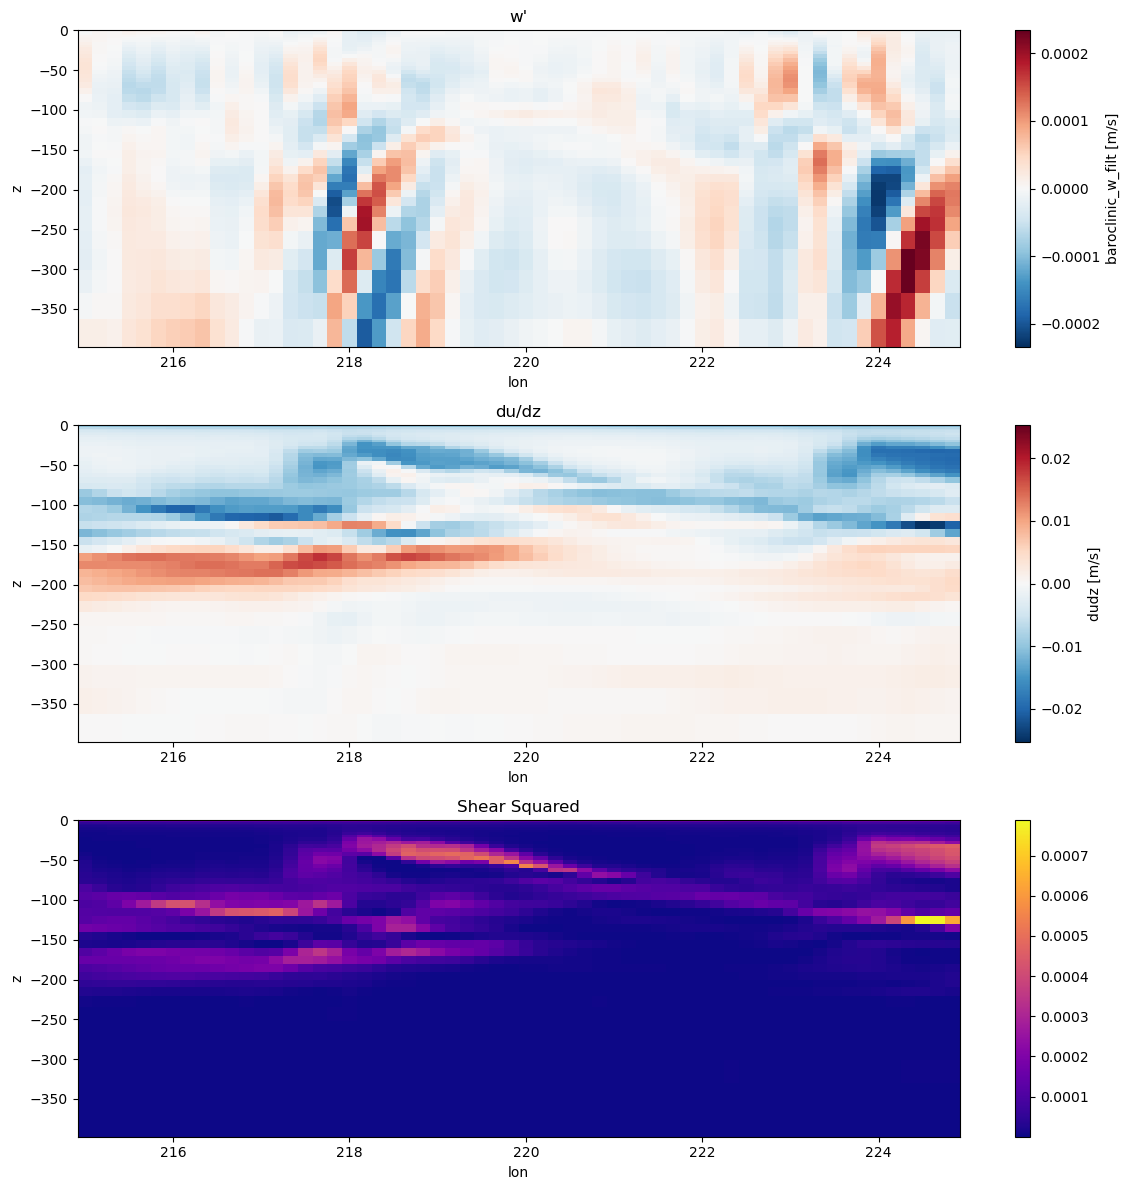

In [47]:
fig, ax = plt.subplots(figsize=(12,12),nrows=3)
baroclinic_w_filt.sel(time=[100.0],lat=[2.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[0],cmap='RdBu_r')
ax[0].set_title('w\'')
dudz.sel(time=[100.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[1],cmap='RdBu_r')
ax[1].set_title('du/dz')
shear_2.sel(time=[100.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[2],cmap='plasma')
ax[2].set_title('Shear Squared')
plt.tight_layout()